In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [54]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    
    llk = pm.Potential("llk", two_gaussians(X))
    trace, nf_models, importance_weights = pm.sample_nfmc(2000, optim_iter=1000, nf_iter=20, chains=1,
                                                          frac_validate=0.2, alpha=(0.5,0.5), parallel=False,
                                                          ftol=1.0e-12)
    az_trace = az.from_pymc3(trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1
Stage:   2
Stage:   3
Stage:   4
Stage:   5
Stage:   6
Stage:   7
Stage:   8
Stage:   9
Stage:  10
Stage:  11
Stage:  12
Stage:  13
Stage:  14
Stage:  15
Stage:  16
Stage:  17
Stage:  18
Stage:  19
Stage:  20


In [55]:
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.202  0.473  -0.668    0.651       0.01    0.008    2229.0  1898.0   
X[1] -0.199  0.468  -0.670    0.611       0.01    0.007    2220.0  1950.0   
X[2] -0.199  0.467  -0.674    0.616       0.01    0.007    2259.0  1945.0   
X[3] -0.204  0.469  -0.677    0.612       0.01    0.008    2274.0  1904.0   

      ess_bulk  ess_tail  r_hat  
X[0]    2162.0    1913.0    NaN  
X[1]    2124.0    1907.0    NaN  
X[2]    2150.0    1823.0    NaN  
X[3]    2213.0    1708.0    NaN  


<Figure size 720x480 with 0 Axes>

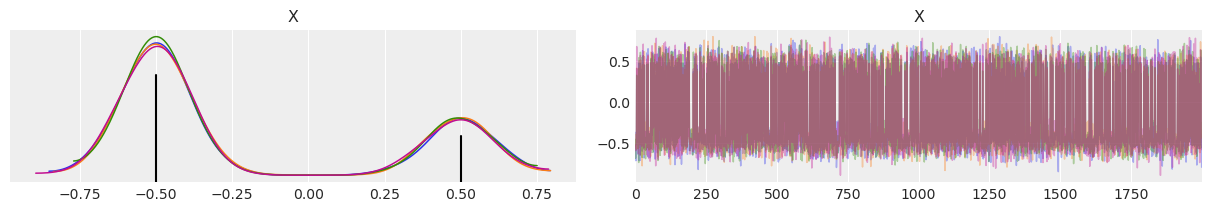

In [56]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

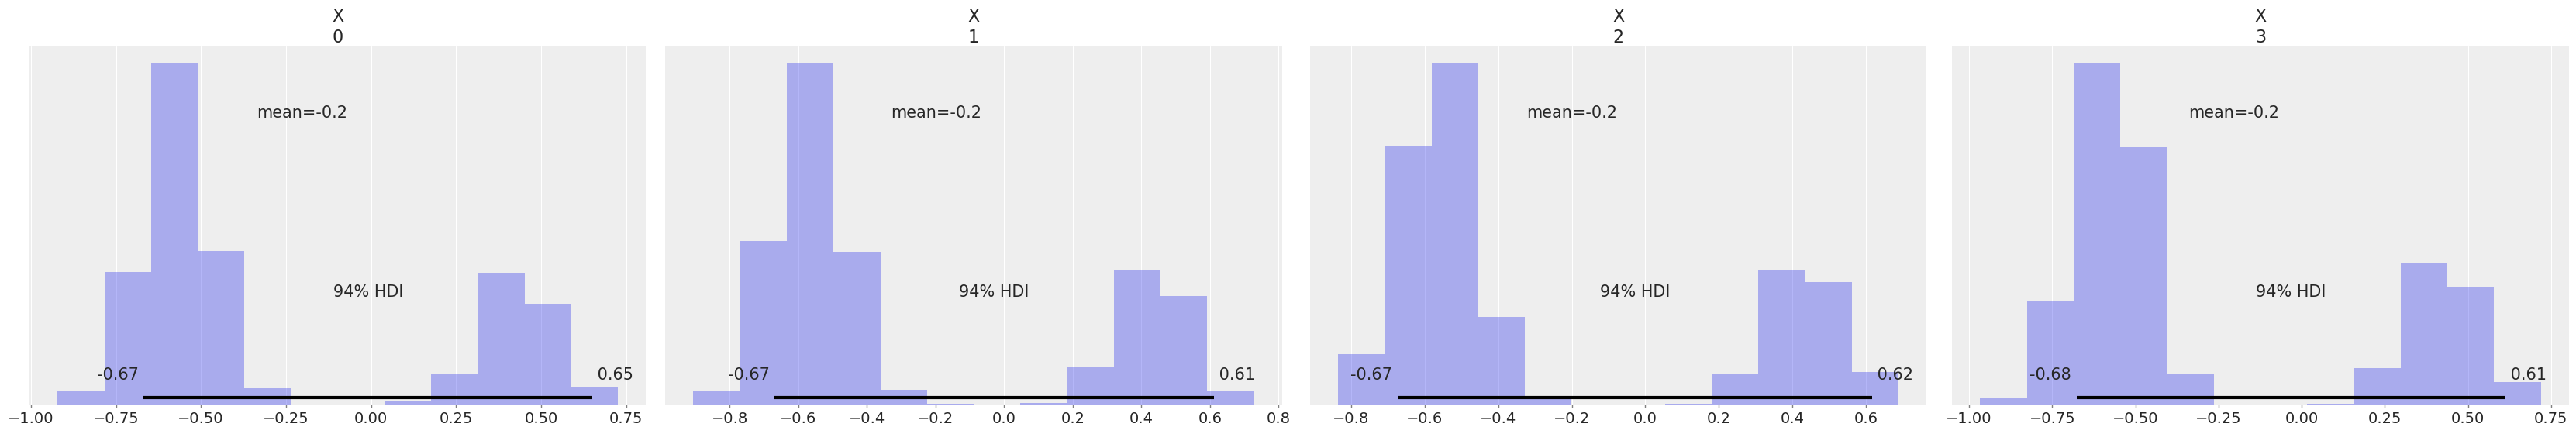

In [59]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


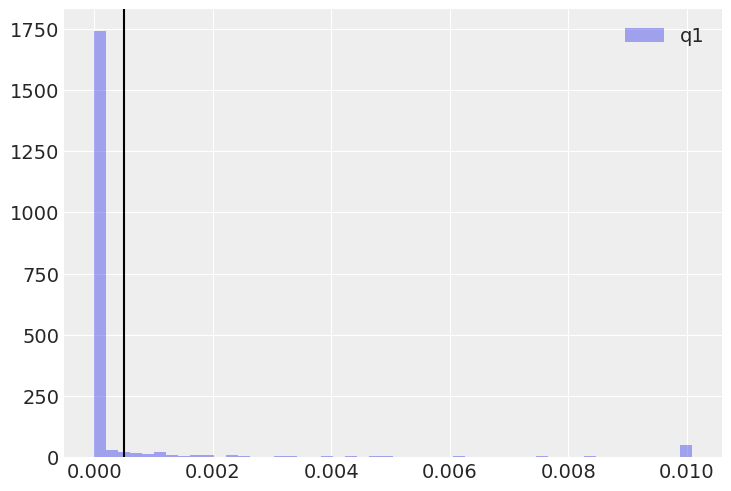

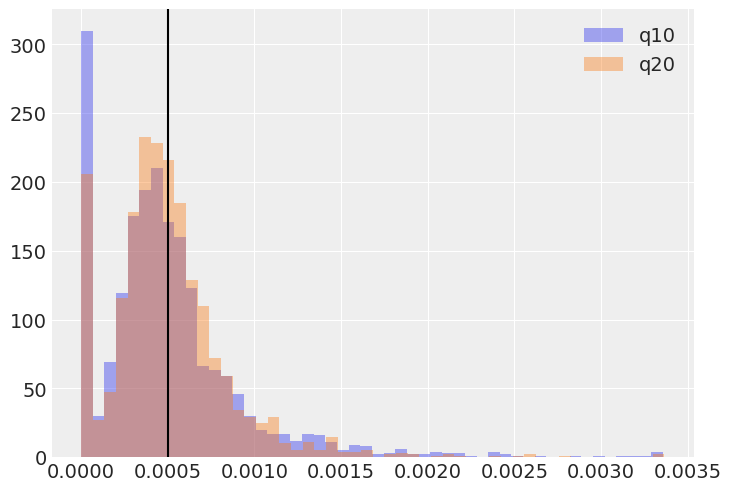

In [6]:
plt.figure()
sns.distplot(importance_weights[0][:2000], kde=False, label='q1')
plt.axvline(x=1/2000, color='k')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(importance_weights[0][(2000*10):(2000*10 + 2000)], kde=False, label='q10')
sns.distplot(importance_weights[0][(2000*20):], kde=False, label='q20')
plt.axvline(x=1/2000, color='k')
plt.legend(loc='upper right')
plt.show()

Let's just check these results against those from SMC. 

In [7]:
with model:
    smc_trace = pm.sample_smc(2000)
    az_smc_trace = az.from_pymc3(smc_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.067
Stage:   3 Beta: 0.147
Stage:   4 Beta: 0.319
Stage:   5 Beta: 0.697
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.063
Stage:   3 Beta: 0.140
Stage:   4 Beta: 0.308
Stage:   5 Beta: 0.656
Stage:   6 Beta: 1.000


In [8]:
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.206  0.469  -0.692    0.607      0.007    0.005    3928.0  3928.0   
X[1] -0.204  0.468  -0.668    0.630      0.007    0.005    4109.0  3703.0   
X[2] -0.202  0.466  -0.680    0.613      0.008    0.005    3847.0  3847.0   
X[3] -0.206  0.467  -0.680    0.613      0.007    0.005    3918.0  3918.0   

      ess_bulk  ess_tail  r_hat  
X[0]    3969.0    3823.0    1.0  
X[1]    4093.0    4004.0    1.0  
X[2]    3735.0    3581.0    1.0  
X[3]    4045.0    3803.0    1.0  


<Figure size 720x480 with 0 Axes>

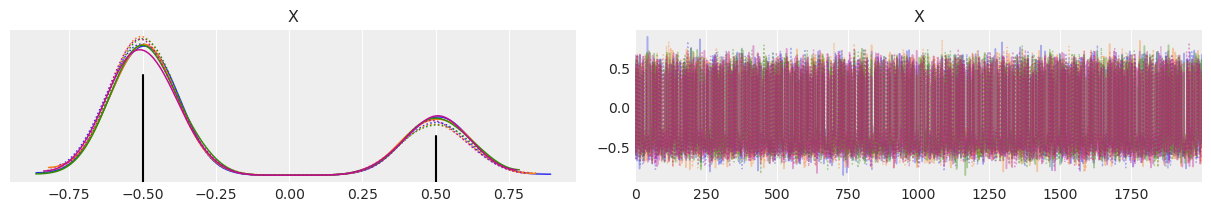

In [9]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

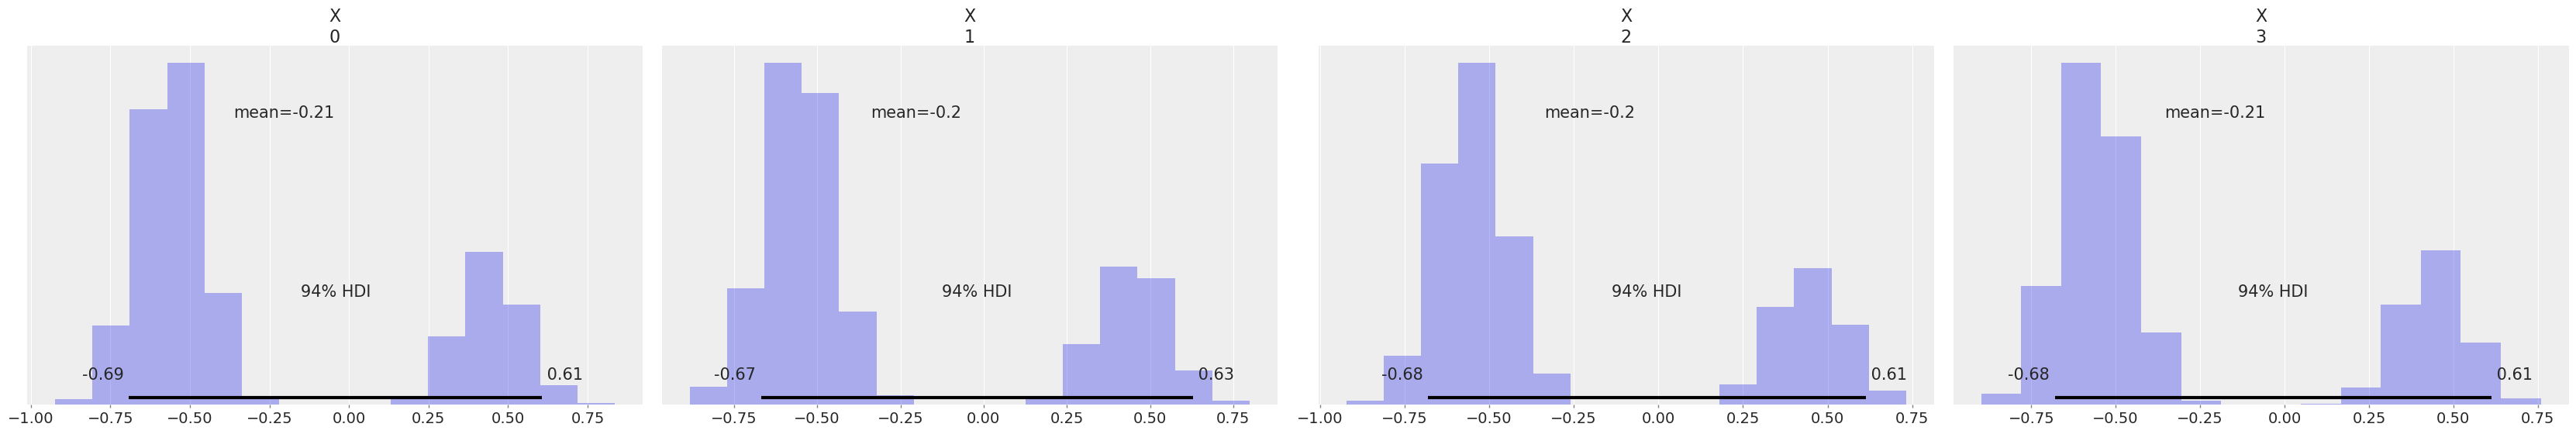

In [10]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

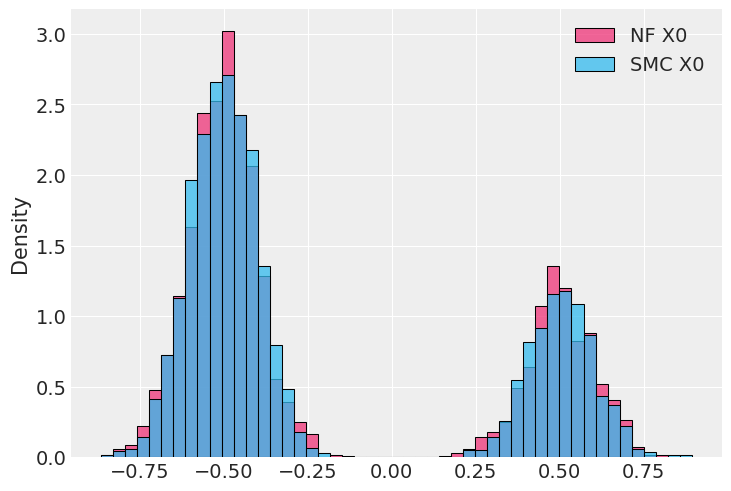

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [66]:
nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.legend(loc='upper right')
plt.show()

'''
plt.figure()
sns.distplot(nf_x1, label='NF X1')
sns.distplot(smc_x1, label='SMC X1')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x2, label='NF X2')
sns.distplot(smc_x2, label='SMC X2')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x3, label='NF X3')
sns.distplot(smc_x3, label='SMC X3')
plt.legend(loc='upper right')
plt.show()
'''

In [28]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    rg_trace, rg_nf_models, rg_importance_weights = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1
Stage:   2
Stage:   3
Stage:   4
Stage:   5
Stage:   6
Stage:   7
Stage:   8
Stage:   9
Stage:  10
Stage:  11
Stage:  12
Stage:  13
Stage:  14
Stage:  15
Stage:  16
Stage:  17
Stage:  18
Stage:  19
Stage:  20


<Figure size 720x480 with 0 Axes>

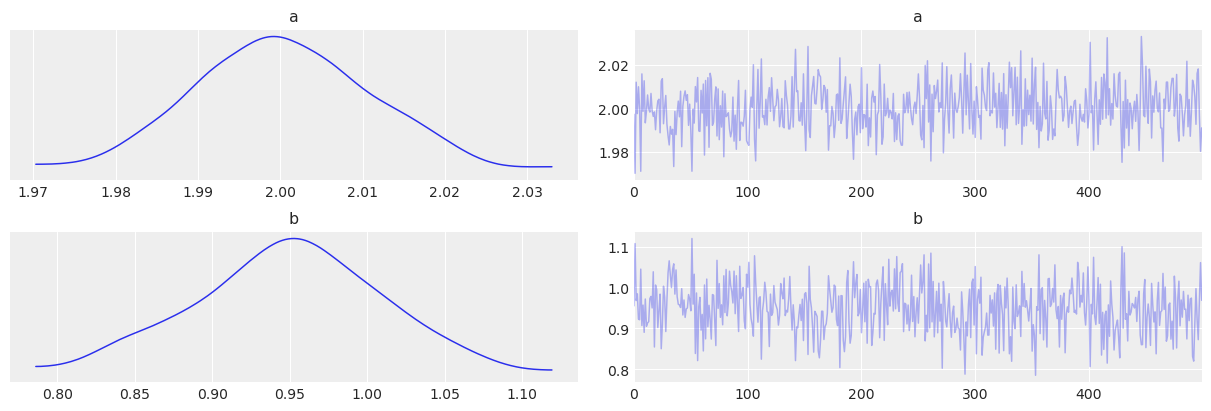

In [29]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


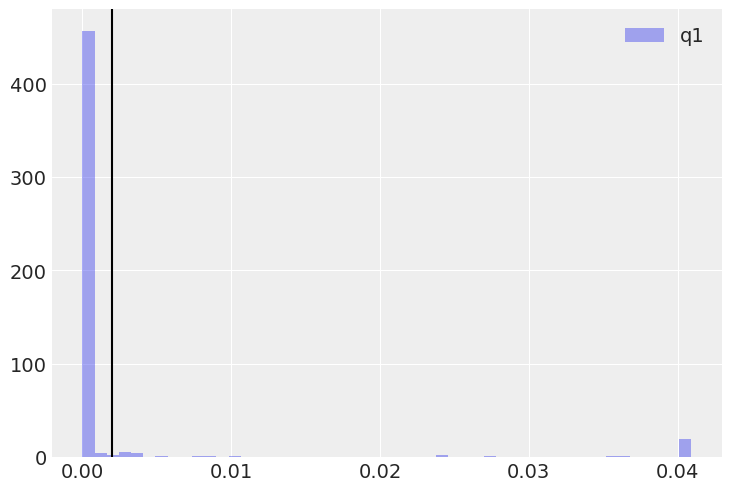

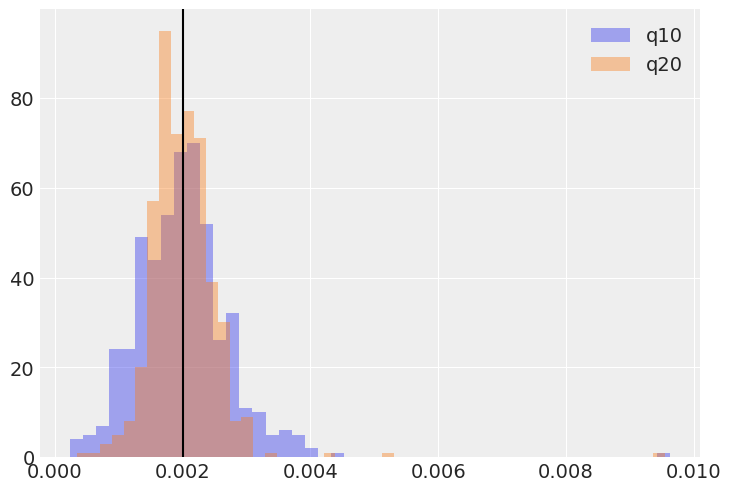

In [30]:
plt.figure()
sns.distplot(rg_importance_weights[0][:500], kde=False, label='q1')
plt.axvline(x=0.002, color='k')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(rg_importance_weights[0][5000:5500], kde=False, label='q10')
sns.distplot(rg_importance_weights[0][10000:], kde=False, label='q20')
plt.axvline(x=0.002, color='k')
plt.legend(loc='upper right')
plt.show()

In [33]:
with rg_model:
    nuts_trace = pm.sample(2000)
    nuts_az_trace = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

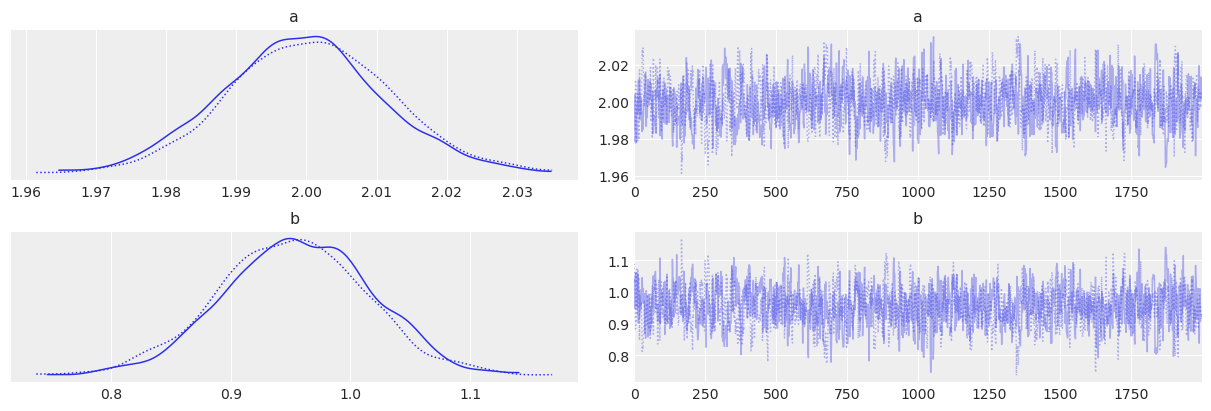

In [34]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

Hierarchical Radon Model ....

In [36]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [37]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [39]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

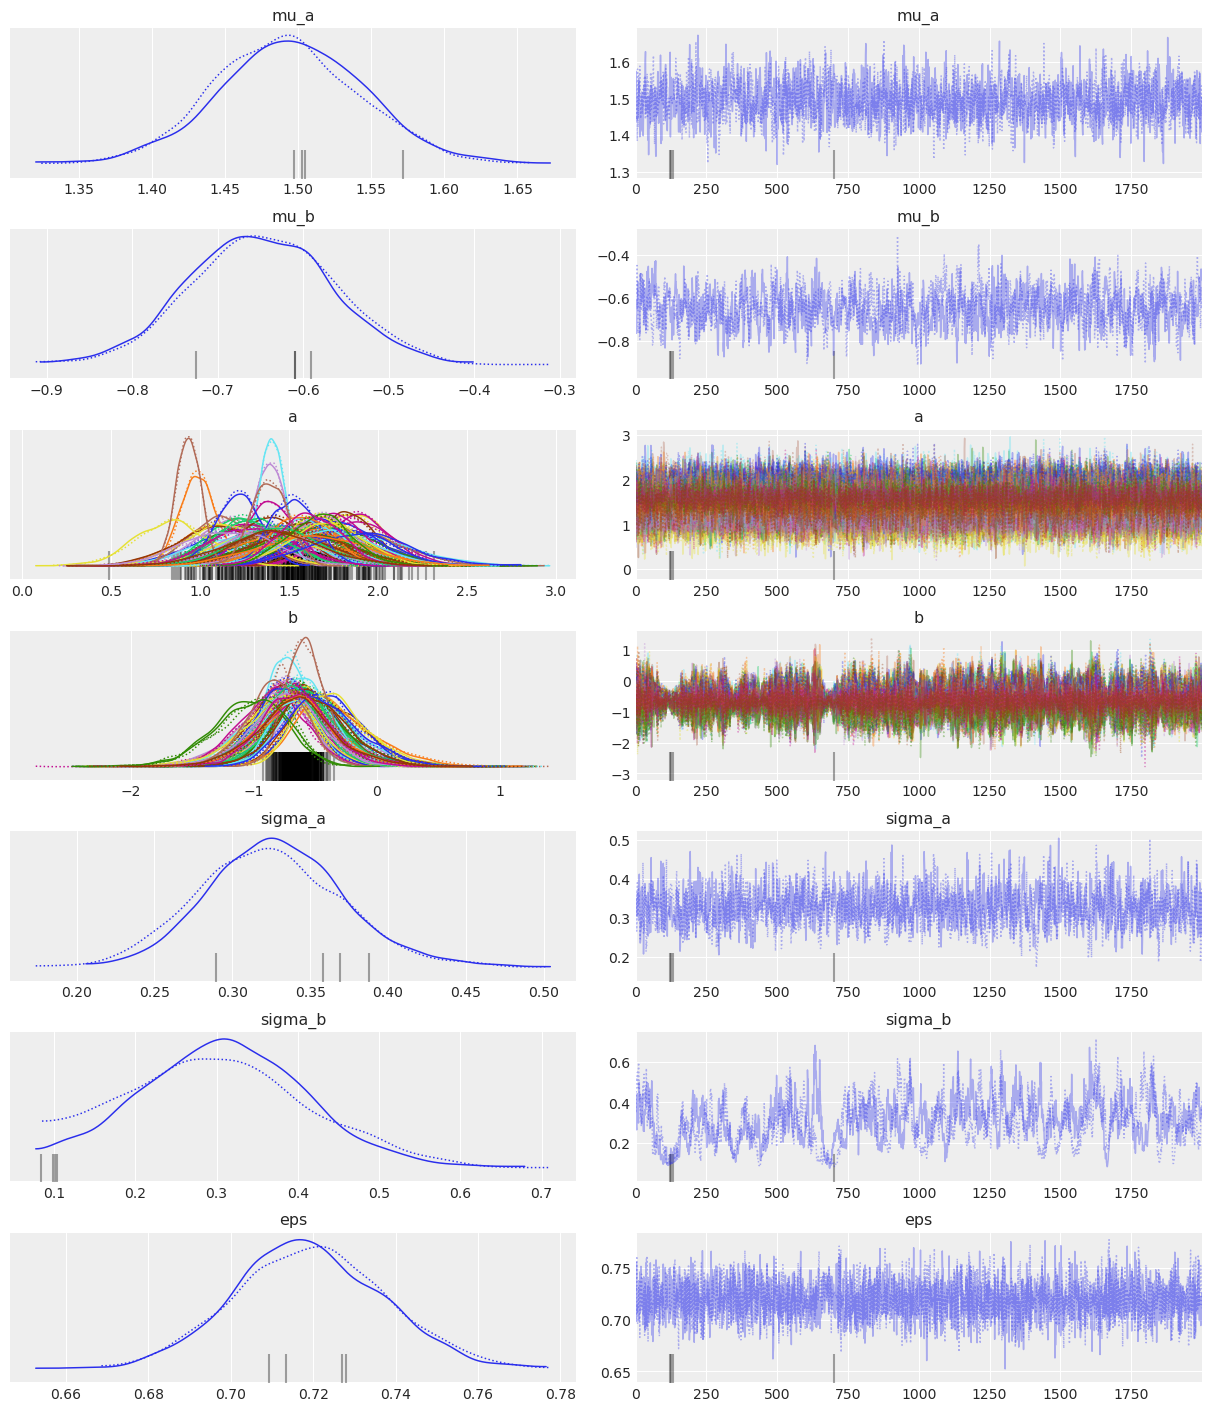

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 